<img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" align="center" alt="" height="45" width="45"/>

# Using custom operators with tf.py_func with Watson Machine Learning


Building models with standard components is straightforward, but to use any custom component with your models in Watson Machine Learning, you need to package your custom component code in a source distribution package and store that package in your Watson Machine Learning repository with your model.

Learn how to define a custom operation using the tf.py_func operation in TensorFlow. The custom operation is then used in a LeNet network for handwritten character recognition which is trained on the MNIST data set. The trained model is persisted, deployed and scored using the Watson Machine Learning Service (WML) and the Watson Machine Learning Client.

Some familiarity with Python is helpful. This notebook uses Python-3.6, numpy-1.14 and tensorflow-1.5. Learn more about custom components in the <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-custom_libs_overview.html" target="_blank" rel="noopener noreferrer">Watson Studio documentation</a>.

## Learning goals

This notebooks focuses particularly on demonstrating how to use custom components in your model. You will learn how to:

-  define a custom operation and corresponding gradient using `tf.py_func`
-  create a LeNet model using the defined custom operation
-  train the model on the MNIST data set
-  create a library containing the custom tensor operation
-  persist the library and the model in Watson Machine Learning repository
-  deploy the model using Watson Machine Learning Service
-  perform some classifications using the deployed model


## Contents

This notebook contains the following parts:

1.  [Set up](#setup)
2.  [Create the operation for tf.py_func and download the library](#func)
3.	[Load data and initialize parameters](#load)
4.	[Create and train the LeNet model](#model)
5.  [Save the LeNet model locally](#save)
6.  [Save the custom library and model in the Watson Machine Learning repository](#lib_persistence)
7.	[Save the LeNet model to the Watson Machine Learning repository](#persistence)
8.  [Deploy and perform prediction on the LeNet model](#Scoring)
9.  [Summary](#summary)


<a id="setup"></a>
## 1. Set up

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://cloud.ibm.com/catalog/services/machine-learning" target="_blank" rel="noopener noreferrer">Watson Machine Learning (WML) Service</a> instance on IBM Cloud (a free plan is offered). Information on how to create the instance is available in the <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener noreferrer">Watson Studio documentation</a>.
- Configure your local python environment:
  + Python 3.6
  + TensorFlow 1.5
  + watson-machine-learning-client


In [1]:
!rm -rf watson-machine-learning-client

In [ ]:
!pip install watson-machine-learning-client --upgrade

<a id="func"></a>
## 2. Configure the tf.py_func function

In this section, you will:
- [Create a custom operation for the tf.py_func](createfunc)
- [Download the Python libraries](downloadlib) that the tf.py_func needs

### 2.1 Create a custom operation for tf.py_func<a id="createfunc"></a>

When you create a custom operation for tf.py_func, you also need to create the corresponding gradient function. TensorFlow maps any function passed to the tf.py_func under the `PyFunc` operation type. TensorFlow models perform gradient calculation during training. Hence, a user defined `tf.py_func` operation requires a corresponding gradient function to be defined and mapped to the `PyFunc` operation type. In this example, `reshape_grad` is the gradient function for the `tf.py_func` operation.

In [ ]:
!pip install --upgrade tensorflow==1.5

In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.python.framework import ops 

def reshape_func(x):
    return x.reshape((-1, 28, 28, 1)) 

def reshape_grad(op, grad):
    x = op.inputs[0]

    return grad

def create_py_func_with_grads(op, inp, tout, stateful=True, name=None, grad=None):
    grad_name = 'PyFuncGrad' + str(np.random.randint(0, 1e+8))

    tf.RegisterGradient(grad_name)(grad)
    g = tf.get_default_graph()

    with g.gradient_override_map({"PyFunc": grad_name}):
        return tf.py_func(op, inp, tout, stateful=stateful, name=name)


### 2.2 Download a sample custom package for a TensorFlow model<a id="downloadlib"></a>

A Python-distributable library needs to be created to store and deploy models that use operations defined through `tf.py_func`. The library must contain an `initialize_py_func()` function, which defines the `tf.py_func` operation. The operation defined within this function must have the same name as the operation created during model definition and training. Also, the `initialize_py_func()` function must be referenceable using the top-level module name. For example, if the top-level module in the python distribution package is `my_top_module`, then `initialize_py_func()` must be referenceable as `my_top_module.initialize_py_func()`.

Currently, only source-distributed libraries archived in `.zip` format are supported. Library distributions of type `wheels` and `eggs` are not supported.

Any 3rd party libraries that are required for the custom transformer must be defined as the dependency for the corresponding library that contains the transformer implementation. 

Download the sample library `custom_reshape_pyfunc.zip`, which defines the reshape operation.

In [5]:
!wget https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/custom-op-hand-written-digit-recognition/libraries/custom_reshape_pyfunc-0.1.zip --output-document=custom_reshape_pyfunc.zip

--2019-07-09 17:51:19--  https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/custom-op-hand-written-digit-recognition/libraries/custom_reshape_pyfunc-0.1.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pmservice/wml-sample-models/master/tensorflow/custom-op-hand-written-digit-recognition/libraries/custom_reshape_pyfunc-0.1.zip [following]
--2019-07-09 17:51:20--  https://raw.githubusercontent.com/pmservice/wml-sample-models/master/tensorflow/custom-op-hand-written-digit-recognition/libraries/custom_reshape_pyfunc-0.1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3138 (3.1K) [application/zip]
Saving to: ‘custom_

<a id="load"></a>
## 3. Load the data and initialize parameters

Download the <a href="http://yann.lecun.com/exdb/mnist/index.html" target="_blank" rel="noopener noreferrer">MNIST data set</a> from Yann LeCun's homepage using the built-in TensorFlow library.

In [6]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Set the training and network parameters.

In [7]:
# Training Parameters
learning_rate = 0.001
training_iters = 10000
batch_size = 128
display_step = 10

# Network Parameters
n_input = 784 
n_classes = 10 

<a id="model"></a>
## 4. Create and train the LeNet model

In this section, you will create the LeNet model and then train it.

Define the placeholders and the default layer configurations for the network.

In [8]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input], name="x_input")
y = tf.placeholder(tf.float32, [None, n_classes])

# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

The `create_py_func_with_grads` function defines a `tf.py_func` operation together with the corresponding gradient and returns the resulting tensor.

In [9]:
x_trans1 = create_py_func_with_grads(reshape_func, [x], tf.float32, False, name='ReshapeFunc', grad=reshape_grad)

Build the model.

In [10]:
# Convolution Layer -1
x_conv2d_l1 = tf.nn.conv2d(x_trans1, weights['wc1'], strides=[1, 1, 1, 1], padding='SAME')
x_w_bias_l1 = tf.nn.bias_add(x_conv2d_l1, biases['bc1'])
x_relu_l1 = tf.nn.relu(x_w_bias_l1)
conv1_out = tf.nn.max_pool(x_relu_l1,
                           ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           padding='SAME')


# Convolution Layer -2
x_conv2d_l2 = tf.nn.conv2d(conv1_out, weights['wc2'], strides=[1, 1, 1, 1], padding='SAME')
x_w_bias_l2 = tf.nn.bias_add(x_conv2d_l2, biases['bc2'])
x_relu_l2 = tf.nn.relu(x_w_bias_l2)
conv2_out = tf.nn.max_pool(x_relu_l2,
                           ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           padding='SAME')

# Fully connected layer
# Reshape conv2 output to fit fully connected layer input
fc1 = tf.reshape(conv2_out, [-1, weights['wd1'].get_shape().as_list()[0]])
fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
fc1 = tf.nn.relu(fc1)

# Output, class prediction
conv_out = tf.add(tf.matmul(fc1, weights['out']), biases['out'], name="output_tensor")

predictor = tf.argmax(conv_out, 1, name="predictor")

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=conv_out, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# To Evaluate model
correct_pred = tf.equal(tf.argmax(conv_out, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



Train the model.

In [11]:
# Initializing the variables
init = tf.global_variables_initializer()
# Launch the graph
sess = tf.Session()
sess.run(init)
step = 1
# Keep training until reach max iterations
while step * batch_size < training_iters:
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    # Run optimization op (backprop)
    sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
    print("Completed batch iteration: " + str(step*batch_size) )
    if step % display_step == 0:
        # Calculate batch loss and accuracy
        loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                          y: batch_y})
    
        print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
              "{:.6f}".format(loss) + ", Training Accuracy= " + \
              "{:.5f}".format(acc))
    step += 1
print("Model training finished!")

Completed batch iteration: 128
Completed batch iteration: 256
Completed batch iteration: 384
Completed batch iteration: 512
Completed batch iteration: 640
Completed batch iteration: 768
Completed batch iteration: 896
Completed batch iteration: 1024
Completed batch iteration: 1152
Completed batch iteration: 1280
Iter 1280, Minibatch Loss= 16422.097656, Training Accuracy= 0.27344
Completed batch iteration: 1408
Completed batch iteration: 1536
Completed batch iteration: 1664
Completed batch iteration: 1792
Completed batch iteration: 1920
Completed batch iteration: 2048
Completed batch iteration: 2176
Completed batch iteration: 2304
Completed batch iteration: 2432
Completed batch iteration: 2560
Iter 2560, Minibatch Loss= 11632.546875, Training Accuracy= 0.47656
Completed batch iteration: 2688
Completed batch iteration: 2816
Completed batch iteration: 2944
Completed batch iteration: 3072
Completed batch iteration: 3200
Completed batch iteration: 3328
Completed batch iteration: 3456
Complet

<a id="save"></a>
## 5. Save the LeNet model locally

In this section, you will use `SavedModelBuilderSave` to save the model locally.

Remove the previously created directory.

In [12]:
import os, shutil
save_path = './tf_model_mnist_test'
# delete dir if directory exists
if os.path.exists(save_path):
    shutil.rmtree(save_path)

Create `SignatureDef` metadata for the model.

In [13]:
classification_inputs = tf.saved_model.utils.build_tensor_info(x)
classification_outputs_classes = tf.saved_model.utils.build_tensor_info(predictor)

classification_signature = (
      tf.saved_model.signature_def_utils.build_signature_def(
          inputs={
              tf.saved_model.signature_constants.CLASSIFY_INPUTS:
                  classification_inputs
          },
          outputs={
              tf.saved_model.signature_constants.CLASSIFY_OUTPUT_CLASSES:
                  classification_outputs_classes
          },
          method_name=tf.saved_model.signature_constants.CLASSIFY_METHOD_NAME))

print("classification_signature content:")
print(classification_signature)

classification_signature content:
inputs {
  key: "inputs"
  value {
    name: "x_input:0"
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: -1
      }
      dim {
        size: 784
      }
    }
  }
}
outputs {
  key: "classes"
  value {
    name: "predictor:0"
    dtype: DT_INT64
    tensor_shape {
      dim {
        size: -1
      }
    }
  }
}
method_name: "tensorflow/serving/classify"



Use TensorFlow's `SavedModelBuilder` API to save the LeNet model locally.

In [14]:
# Build the signature_def_map.

builder = tf.saved_model.builder.SavedModelBuilder(save_path)
legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')
builder.add_meta_graph_and_variables(
      sess, [tf.saved_model.tag_constants.SERVING],
      signature_def_map={
          'predict_images': classification_signature,
      },
      legacy_init_op=legacy_init_op)

builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'./tf_model_mnist_test/saved_model.pb'


b'./tf_model_mnist_test/saved_model.pb'

<a id="lib_persistence"></a>
## 6. Save the custom library and model in the Watson Machine Learning repository


In this section, use the `watson_machine_learning_client` to:
- Save the library `custom_reshape_pyfunc.zip` in the WML Repository by creating a library resource.
- Create a runtime resource and bind the library resource to it. This runtime resource will be used to configure the online deployment runtime environment for a model.


### 6.1 Save the library as a library artifact

Authenticate to the Watson Machine Learning (WML) service on IBM Cloud.

Authentication information (your credentials) can be found in the <a href="https://console.bluemix.net/docs/services/service_credentials.html#service_credentials" target="_blank" rel="noopener noreferrer">Service Credentials</a> tab of the service instance that you created on IBM Cloud. 
If there are no credentials listed for your instance in **Service credentials**, click **New credential (+)** and enter the information required to generate new authentication information. 

**Action**: Enter your WML service instance credentials here.

In [15]:
wml_credentials = {
    "apikey": "...",
    "username": "...",
    "password": "...",
    "instance_id": "...",
    "url": "https://ibm-watson-ml.mybluemix.net"
}

In [17]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [18]:
client = WatsonMachineLearningAPIClient(wml_credentials)

When you create the library metadata for storing the library in WML Repository, make sure that the value passed to `client.runtimes.LibraryMetaNames.NAME` key is the same as the value passed to the `name` parameter of `setup()` function in `setup.py` file which is used to build the library.

In [19]:
cust_lib_zip_path = "custom_reshape_pyfunc.zip"

In [20]:
lib_meta = {
    client.runtimes.LibraryMetaNames.NAME: "custom_reshape_pyfunc",
    client.runtimes.LibraryMetaNames.DESCRIPTION: "A custom pyfunc lib which reshapes input",
    client.runtimes.LibraryMetaNames.FILEPATH: cust_lib_zip_path,
    client.runtimes.LibraryMetaNames.VERSION: "1.2",
    client.runtimes.LibraryMetaNames.PLATFORM: {"name": "python", "versions": ["3.5"]}
}

In [21]:
custom_library_details = client.runtimes.store_library(lib_meta)

In [22]:
client.runtimes.list_libraries()

------------------------------------  ---------------------  -------  ------------------------  -------------  -----------------
GUID                                  NAME                   VERSION  CREATED                   PLATFORM NAME  PLATFORM VERSIONS
7090989e-a4fd-443d-a58b-7853270afcf7  custom_reshape_pyfunc  1.2      2019-07-09T17:52:57.672Z  python         ['3.5']
b98fd429-1c59-43bf-9274-ac6c9d499c08  sklearn_arima          0.1      2019-07-03T00:55:07.237Z  python         ['3.5']
------------------------------------  ---------------------  -------  ------------------------  -------------  -----------------


In [23]:
custom_library_uid = client.runtimes.get_library_uid(custom_library_details)

In [24]:
custom_library_uid

'7090989e-a4fd-443d-a58b-7853270afcf7'

### 6.2 Save the runtime resource artifact
The runtime resource artifact contains references to a collection of all the custom libraries that need to be used together to deploy the model.
When you create the metadata to store the runtime artifact, pass a list of library uids that need to be used to the `client.runtimes.ConfigurationMetaNames.LIBRARIES_UIDS` key.

In [25]:
runtime_meta = {
    client.runtimes.ConfigurationMetaNames.NAME: 'runtime_mnist',
    client.runtimes.ConfigurationMetaNames.DESCRIPTION: 'runtime spec - mnist',
    client.runtimes.ConfigurationMetaNames.PLATFORM: {
        "name": "python",
        "version": "3.5"
    },
    client.runtimes.ConfigurationMetaNames.LIBRARIES_UIDS: [custom_library_uid]
}
runtime_details = client.runtimes.store(runtime_meta)

In [26]:
runtime_details

{'metadata': {'guid': '55a5c250-b93d-4cad-b58c-d83175bfd9da',
  'url': 'https://us-south.ml.cloud.ibm.com/v4/runtimes/55a5c250-b93d-4cad-b58c-d83175bfd9da',
  'created_at': '2019-07-09T17:52:59.448Z'},
 'entity': {'name': 'runtime_mnist',
  'description': 'runtime spec - mnist',
  'custom_libraries': [{'name': 'custom_reshape_pyfunc',
    'version': '1.2',
    'url': 'https://us-south.ml.cloud.ibm.com/v4/libraries/7090989e-a4fd-443d-a58b-7853270afcf7'}],
  'content_url': 'https://us-south.ml.cloud.ibm.com/v4/runtimes/55a5c250-b93d-4cad-b58c-d83175bfd9da/content',
  'platform': {'name': 'python', 'version': '3.5'}}}

In [27]:
custom_runtime_uid = client.runtimes.get_uid(runtime_details)
print(custom_runtime_uid)

55a5c250-b93d-4cad-b58c-d83175bfd9da


<a id="persistence"></a>
## 7. Save the LeNet model to the Watson Machine Learning repository

The model that needs to be saved in the repo needs to be of tar.gz format.

### 7.1 Create a model archive

First, remove any existing model archive with the same name, then create a new one.

In [28]:
if os.path.exists('tf_mnist_pyfunc.tar.gz'):
    os.remove('tf_mnist_pyfunc.tar.gz')

In [29]:
cd tf_model_mnist_test

/home/dsxuser/work/tf_model_mnist_test


In [30]:
ls

saved_model.pb  variables/


In [31]:
!tar -cvf ../tf_mnist_pyfunc.tar *

saved_model.pb
variables/
variables/variables.index
variables/variables.data-00000-of-00001


In [32]:
cd ../

/home/dsxuser/work


In [33]:
!gzip tf_mnist_pyfunc.tar

In [34]:
model_path = 'tf_mnist_pyfunc.tar.gz'

### 7.2 Save the model to the Watson Machine Learning repository
Bind Runtime resource to the model and save the model to Watson Machine Learning repository. <br>
`client.repository.ModelMetaNames.RUNTIME_UID` key value pair is added to the model metadata as a reference to the runtime artifact which stores the list of library artifact urls.

In [ ]:
model_meta = {
    client.repository.ModelMetaNames.AUTHOR_NAME: "IBM",
    client.repository.ModelMetaNames.AUTHOR_EMAIL: "ibm@ibm.com",
    client.repository.ModelMetaNames.NAME: "cust_pyfunc_mnist",
    client.repository.ModelMetaNames.DESCRIPTION: "cust MNIST with pyfunc",
    client.repository.ModelMetaNames.RUNTIME_UID: custom_runtime_uid,
    client.repository.ModelMetaNames.FRAMEWORK_NAME: "tensorflow",
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: "1.5",
    client.repository.ModelMetaNames.RUNTIME_NAME: "python",
    client.repository.ModelMetaNames.RUNTIME_VERSION: "3.5"
}
model_details = client.repository.store_model(model=model_path, meta_props=model_meta)

In [36]:
model_uid = client.repository.get_model_uid(model_details)
print(model_uid)

9fa55b5e-45f5-46ae-829e-42d8c038017a


In [37]:
model_details

{'metadata': {'guid': '9fa55b5e-45f5-46ae-829e-42d8c038017a',
  'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/b4b6c696-172c-4164-8049-c0b621dbf3c9/published_models/9fa55b5e-45f5-46ae-829e-42d8c038017a',
  'created_at': '2019-07-09T17:53:04.949Z',
  'modified_at': '2019-07-09T17:53:05.026Z'},
 'entity': {'runtime_environment': 'python-3.5',
  'learning_configuration_url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/b4b6c696-172c-4164-8049-c0b621dbf3c9/published_models/9fa55b5e-45f5-46ae-829e-42d8c038017a/learning_configuration',
  'author': {'name': 'IBM'},
  'name': 'cust_pyfunc_mnist',
  'description': 'cust MNIST with pyfunc',
  'learning_iterations_url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/b4b6c696-172c-4164-8049-c0b621dbf3c9/published_models/9fa55b5e-45f5-46ae-829e-42d8c038017a/learning_iterations',
  'feedback_url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/b4b6c696-172c-4164-8049-c0b621dbf3c9/published_models/9fa55b5e-45f5-46ae-829e-

<a id='Scoring'></a>
## 8. Deploy and perform prediction on the LeNet model

In this section, you will:
- Deploy the saved model that uses the custom transformer
- Perform predictions
You will use the WML client to perform these tasks.

### 8.1 Deploy the model

In [38]:
deployment_details = client.deployments.create(model_uid, "Mnist model deployment")



#######################################################################################

Synchronous deployment creation for uid: '9fa55b5e-45f5-46ae-829e-42d8c038017a' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS.................
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='7e4cc05a-9868-4ea7-b502-b2a56324d686'
------------------------------------------------------------------------------------------------




### 8.2 Score the deployed model

Get the scoring url for the model.

In [ ]:
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

Prepare sample scoring data.

In [40]:
import matplotlib.pyplot as plt
import numpy as np

In [41]:
image = mnist.test.next_batch(1)[0].tolist()
payload = {'values': image}

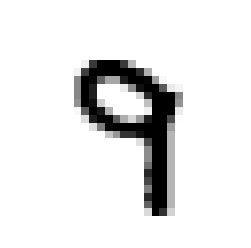

In [42]:
plt.subplot(1, 1, 1)
plt.axis('off')
plt.imshow((np.reshape(np.array(image), (28, 28)) * 255).astype(np.uint8), cmap=plt.cm.gray_r, interpolation='nearest')

In [43]:
predictions = client.deployments.score(scoring_url, payload)
print('Scoring result: ' + str(predictions['values']))

Scoring result: [4]


### 8.3 Delete the deployments, libaries, models and runtimes

Use the following method to delete the deployment if it is no longer needed.

In [44]:
deployment_id = client.deployments.get_uid(deployment_details)

In [45]:
client.deployments.delete(deployment_id)

'SUCCESS'

Check that all your deployments are deleted.

In [46]:
client.deployments.list()

------------------------------------  -------------------------------------------------------  -------  ------------------  ------------------------  -----------------  -------------
GUID                                  NAME                                                     TYPE     STATE               CREATED                   FRAMEWORK          ARTIFACT TYPE
af073cc6-dca4-42d3-a27e-9892e8bfc3c0  Keras MNIST model deployment through compressed file.    online   DEPLOY_SUCCESS      2019-07-09T17:50:11.230Z  tensorflow-1.5     model
7985e484-4192-400e-82e5-3756d4600668  ARIMA model python function deployment                   online   DEPLOY_SUCCESS      2019-07-03T20:33:40.817Z  n/a                function
6aedb5b7-638a-4388-ab0d-45fecb3b7081  Customer Churn Prediction                                online   DEPLOY_SUCCESS      2019-07-03T15:51:34.166Z  mllib-2.3          model
cfcd5f9e-5b07-4bea-b57d-304c12254add  sklearn_pipeline_arima                                   online   DE

Delete the library, model or runtime by passing in the appropriate GUID:

In [47]:
client.repository.delete(model_uid)

'SUCCESS'

In [48]:
client.repository.delete(custom_library_uid)

'SUCCESS'

In [49]:
client.repository.delete(custom_runtime_uid)

'SUCCESS'

<a id="summary"></a>
## 9. Summary

In this notebook we learnt how to create a custom Python operation using TensorFlow's `tf.py_func` and used it on the LeNet model for MNIST.

We also learned how to use the `watson-machine-learning-client` to store a library created to use the same operation into theWML Repository.

Finally, we stored our custom LeNet model with references to the created library into WML Repository, and this model could be deployed and scored later using the WML Service.

To explore the functionalities of Watson Studio further, check out our <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener noreferrer">Online Documentation</a> for more samples, tutorials, documentation, how-tos, and blog posts.

### References
Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11):2278-2324, November 1998.

Creative Commons Zero v1.0 Universal License: The code in section [2.1 Create a custom operation for tf.py_func](#2.1-Create-a-custom-operation-for-tf.py_func) is based on the following:
- https://github.com/tensorflow/tensorflow/issues/1095
- https://gist.github.com/harpone/3453185b41d8d985356cbe5e57d67342

### Author
**Srikrishna S Bhat**, M. Tech, is a Software Engineer at IBM Watson Machine Learning Team

<hr>
Copyright © 2018, 2019 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>